In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.prepare_data import most_recent_thursday, split_time
from help_functions.calculate_score import evaluate_horizon
from help_functions.evaluate_energymodels import evaluate_energymodel, evaluate_different_energymodels

from energy_consumption.help_functions.get_energy_data import get_data
from energy_consumption.models.ec_model1 import get_ec_forecasts_model1

In [5]:
df = get_data()
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


In [6]:
df_cval

,energy_consumption
date_time,
2021-12-20 00:00:00,49.57150
2021-12-20 01:00:00,47.99850
2021-12-20 02:00:00,47.46700
2021-12-20 03:00:00,47.96675
2021-12-20 04:00:00,49.45700
...,...
2023-11-16 07:00:00,64.98925
2023-11-16 08:00:00,66.97700
2023-11-16 09:00:00,67.41050


In [7]:
# Functions work
model = {
    'name': 'model1',
    'function': get_ec_forecasts_model1
}
evaluation1 = evaluate_energymodel(model, df_cval, last_x=10,weeks=True)

models = [model]
evaluation2 = evaluate_different_energymodels(models,df_cval, last_x=10, weeks=True)

Iteration 2 of 10


C:\Users\Maria\Documents\Studium\Pyhton Projekte\PTSFC\energy_consumption\help_functions\dummy_mapping.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, 'month'] = data_df.index.month


                     winter  spring  autumn  working_day  saturday  hour_1  \
date_time                                                                    
2023-11-09 12:00:00       0       0       1            1         0       0   
2023-11-09 13:00:00       0       0       1            1         0       0   
2023-11-09 14:00:00       0       0       1            1         0       0   
2023-11-09 15:00:00       0       0       1            1         0       0   
2023-11-09 16:00:00       0       0       1            1         0       0   
...                     ...     ...     ...          ...       ...     ...   
2023-11-14 07:00:00       0       0       1            1         0       0   
2023-11-14 08:00:00       0       0       1            1         0       0   
2023-11-14 09:00:00       0       0       1            1         0       0   
2023-11-14 10:00:00       0       0       1            1         0       0   
2023-11-14 11:00:00       0       0       1            1        

In [8]:
models

[{'name': 'model1',
  'function': <function energy_consumption.models.ec_model1.get_ec_forecasts_model1(energydata=Empty DataFrame
Columns: []
Index: [], indexes=[27, 31, 35, 51, 55, 59])>,
  'evaluation':                     forecast_date  target  horizon     q0.025      q0.25  \
  date_time                                                                  
  2023-11-10 15:00:00    2023-11-18  energy  36 hour  43.853001  49.098250   
  2023-11-10 19:00:00    2023-11-18  energy  40 hour  42.411000  51.469000   
  2023-11-10 23:00:00    2023-11-18  energy  44 hour  36.988250  39.098000   
  2023-11-11 15:00:00    2023-11-18  energy  60 hour  47.251251  49.691003   
  2023-11-11 19:00:00    2023-11-18  energy  64 hour  45.809250  52.061752   
  2023-11-11 23:00:00    2023-11-18  energy  68 hour  40.386500  39.690752   
  2023-11-03 15:00:00    2023-11-18  energy  36 hour  43.586749  48.507500   
  2023-11-03 19:00:00    2023-11-18  energy  40 hour  44.339249  49.359999   
  2023-11-03 23:

### Visualize Comparison 

1. Create a table that only contains the different scores of the different models

In [9]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

2.  Plot the densities of the obtained scores

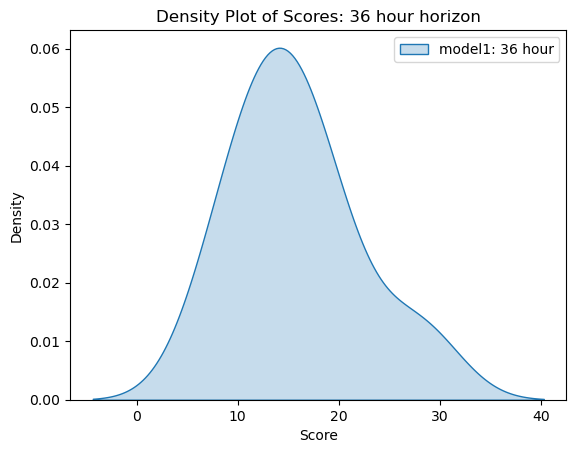

In [10]:
sns.kdeplot(data=score_df.loc[:, ['model1: 36 hour']], fill=True)

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Density Plot of Scores: 36 hour horizon')

# Display the plot
plt.show()

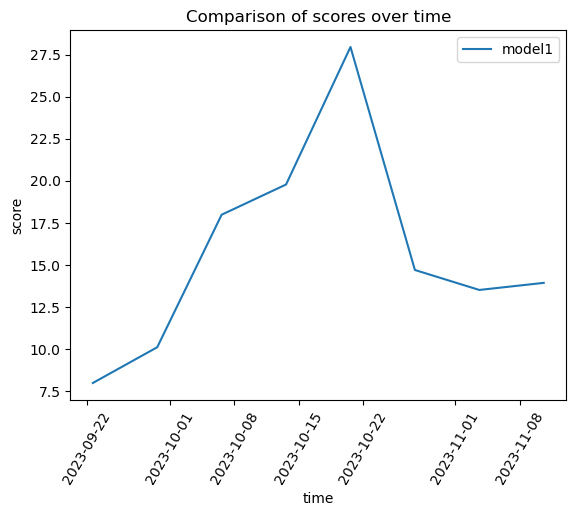

In [11]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['model1: 36 hour'].notna()]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['model1: 36 hour'], label='model1')

# Adding labels and title
plt.xlabel('time')
plt.xticks(rotation=60)
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()